# Building CNN From Scratch With Keras For Cancer Detection
***By Kris Smith***

## Import Libraries

In [1]:
import numpy as np, pandas as pd, tensorflow as tf
import os
import cv2
from PIL import Image 
from glob import glob 
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from tensorflow.keras.models import load_model
from keras.layers.normalization import *
from keras.layers.convolutional import *
from keras.layers.core import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline


print(os.listdir("../input/histopathologic-cancer-detection"))
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################################



# import os, cv2
# from scipy import stats

# from tqdm import tqdm_notebook,trange

# from time import time

# from sklearn.model_selection import train_test_split

# from keras.applications.vgg16 import VGG16

# from keras.callbacks import TensorBoard

# # import the necessary packages
# from keras.models import Sequential
# # from keras.layers.normalization import BatchNormalization
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation
# from keras.layers.core import Flatten
# from keras.layers.core import Dropout
# from keras.layers.core import Dense
# from keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['sample_submission.csv', 'train_labels.csv', 'test', 'train']
Num GPUs Available:  1


---

# EDA

## Load Data

In [2]:
print(f'Total Number of Samples in Training Data = {len(os.listdir("../input/histopathologic-cancer-detection/train"))}')
print(f'Total Number of Samples in Test Data = {len(os.listdir("../input/histopathologic-cancer-detection/test"))}')

Total Number of Samples in Training Data = 220025
Total Number of Samples in Test Data = 57458


In [3]:
path = "../input/histopathologic-cancer-detection/"
train_path = path + 'train/'
test_path = path + 'test/'

### Read data into pandas frames ###
## Load training and testing file names into frames
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) 

## Isolate the id from file names and store as id features in seperate column
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) 

## Read in training labels
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## Add Labels to training data 
df = df.merge(labels, on = "id") # merge labels and filepaths
df.sample(7)

,path,id,label
85221,../input/histopathologic-cancer-detection/trai...,3eaa63a27583ccb0aa6d678ea9bf53b35cef4c7b,1
7760,../input/histopathologic-cancer-detection/trai...,3535514b85cd208eea32d3cbe67e0a4f8deb93c1,0
147790,../input/histopathologic-cancer-detection/trai...,2d0e24e8aef15a0cc60be7b13d83a08ec598a85b,1
142025,../input/histopathologic-cancer-detection/trai...,9e068294f8ccffa52a4d16c90c9a22d3f6212736,0
44073,../input/histopathologic-cancer-detection/trai...,7a14ba99f5ba2bca956cc04d6472a9b4ece5bc08,0
108738,../input/histopathologic-cancer-detection/trai...,5ed52c9e48ce6b34fa0de3e133982972e6d2e1fd,0
138491,../input/histopathologic-cancer-detection/trai...,f377b6cce4320f7568699fa2b9b06cf370c52dd5,0


## Lets Inspect Distribution Among The Classes in Training Data

<AxesSubplot: title={'center': 'Class Distribution in Training Data'}>

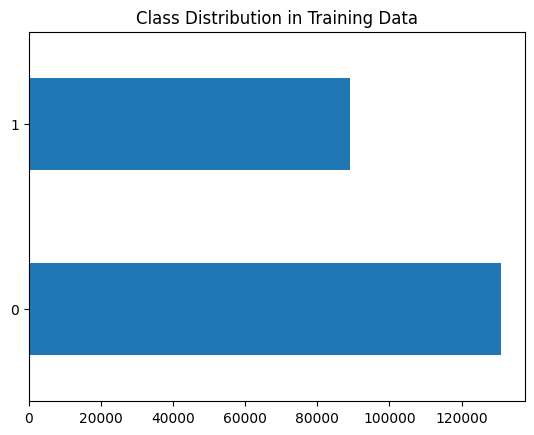

In [4]:
labels['label'].value_counts().plot(kind='barh', title='Class Distribution in Training Data')

## Inspect Some Samples From Both Positive and Negative Classes

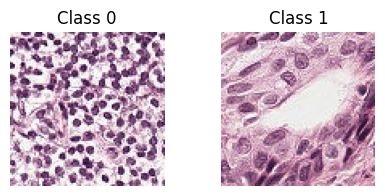

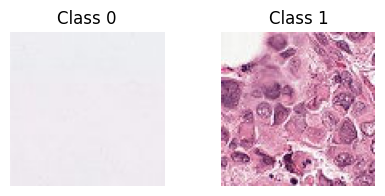

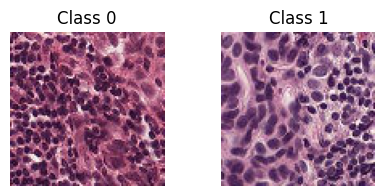

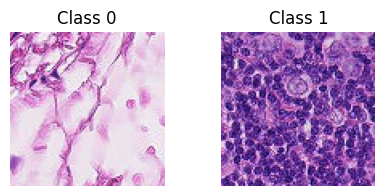

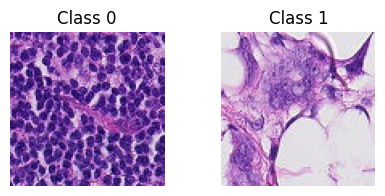

In [5]:
## Filter dataframe to get a subset of each class
class0 = df[df['label'] == 0]
class1 = df[df['label'] == 1]

for image in range(5):
    ## Select a random sample from each class
    sample0 = class0.sample(1)
    sample1 = class1.sample(1)

    ## Open image files and plot
    img_path0 = sample0['path'].values[0]
    img_path1 = sample1['path'].values[0]

    img0 = Image.open(img_path0)
    img1 = Image.open(img_path1)

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))

    ax[0].imshow(img0)
    ax[0].set_title('Class 0')
    ax[0].axis('off')

    ax[1].imshow(img1)
    ax[1].set_title('Class 1')
    ax[1].axis('off')

    plt.show()

***Apparently metastatic cells should appear a different size, shape, or pattern compared to the cells around them. Inspecting these images I am realizing that I am not a medical professional and therefore I can see no obvious differences between the positive and negative class images. Therefore I will be relying on the labels and the model to distinguish between the two.***

---
# Training

## Split Training Data

In [6]:
# !pip install git+https://github.com/keras-team/keras-preprocessing.git
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
# df = df.sample(12800)

df['label'] = df['label'].astype(str)
# df = df.sample(640)

def append_ext(ID):
    return(ID+".tif")


df["id"] = df["id"].apply(append_ext)



train_datagen = ImageDataGenerator(
       horizontal_flip=True,
       vertical_flip=True,
       #brightness_range=[0.5, 1.5],
       #fill_mode='reflect',                               
        rotation_range=15,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2
        validation_split=0.10
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '../input/histopathologic-cancer-detection/train'
valid_path = '../input/histopathologic-cancer-detection/train'

train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='training',
                target_size=(96, 96),
                batch_size=16,
                class_mode='binary'
                )

validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='validation', 
                target_size=(96, 96),
                batch_size=16,
                shuffle=False,
                class_mode='binary'
                )

Found 11520 validated image filenames belonging to 2 classes.
Found 1280 validated image filenames belonging to 2 classes.


## Building Model Architecture

### Model 1

In [35]:
with tf.device('/gpu:0'):  
    model = Sequential()
    
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#     STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

#     history = model.fit(train_generator,
#                         steps_per_epoch=STEP_SIZE_TRAIN,
#                         epochs=15,
#                         validation_data=validation_generator,
#                         validation_steps=STEP_SIZE_VALID)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 96, 96, 16)        2320      
                                                                 
 conv2d_18 (Conv2D)          (None, 96, 96, 16)        2320      
                                                                 
 dropout_10 (Dropout)        (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        4640      
                                                      

### Model 2

In [8]:
with tf.device('/gpu:0'):  
    model = Sequential()
    
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
#     model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID)


Epoch 1/10


2023-05-28 00:14:19.856771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


720/720 [==============================] - 106s 136ms/step - loss: 0.5435 - accuracy: 0.7344 - val_loss: 0.6408 - val_accuracy: 0.6203
Epoch 2/10
720/720 [==============================] - 46s 64ms/step - loss: 0.4792 - accuracy: 0.7853 - val_loss: 0.6085 - val_accuracy: 0.6773
Epoch 3/10
720/720 [==============================] - 46s 64ms/step - loss: 0.4702 - accuracy: 0.7899 - val_loss: 0.5932 - val_accuracy: 0.6820
Epoch 4/10
720/720 [==============================] - 46s 63ms/step - loss: 0.4558 - accuracy: 0.7927 - val_loss: 0.5776 - val_accuracy: 0.6914
Epoch 5/10
720/720 [==============================] - 46s 65ms/step - loss: 0.4551 - accuracy: 0.7912 - val_loss: 0.6292 - val_accuracy: 0.6344
Epoch 6/10
720/720 [==============================] - 46s 63ms/step - loss: 0.4468 - accuracy: 0.8028 - val_loss: 0.5128 - val_accuracy: 0.7430
Epoch 7/10
720/720 [==============================] - 46s 64ms/step - loss: 0.4397 - accuracy: 0.8059 - val_loss: 0.4818 - val_accuracy: 0.7883
E

In [9]:
model.evaluate_generator(generator=validation_generator)

/tmp/ipykernel_32/855669297.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(generator=validation_generator)


[0.44597214460372925, 0.803906261920929]

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

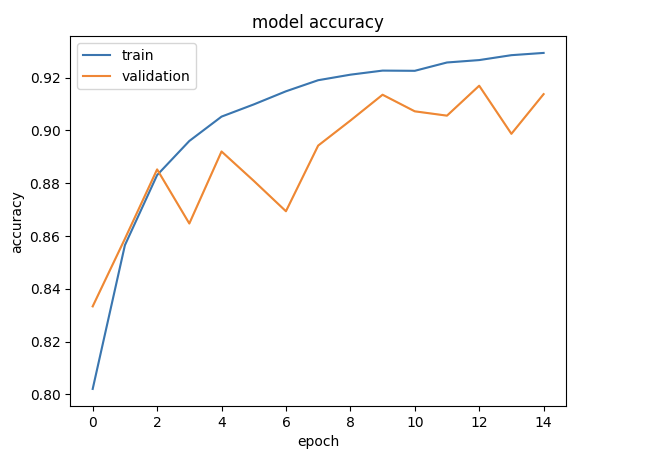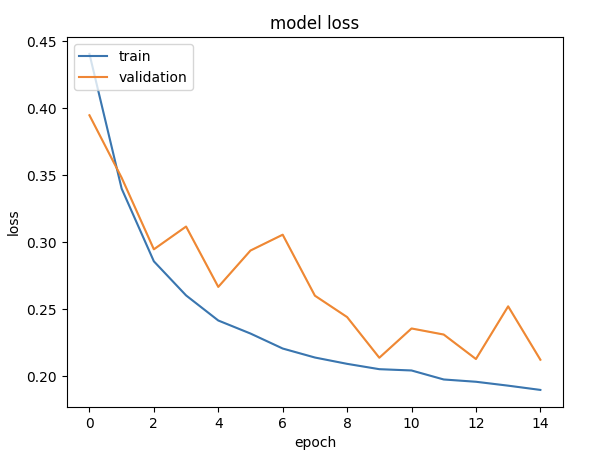

In [11]:
# Save the model
model.save('Keras_CNN_3.h5')  

In [32]:
with tf.device('/GPU:0'):
    model = load_model('/kaggle/input/cancer-detections-cnn2/Keras_CNN_1.h5')

test_df = pd.read_csv(path + 'sample_submission.csv')

TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join(test_path,'*.tif'))
submission = pd.DataFrame()
print(len(testing_files))

for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    
    # Stack images into a batch
    images = np.stack(data_frame.image, axis=0) / 255.0
    # Predict on the entire batch
    predictions = model.predict(images).flatten()
    
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])

submission.to_csv('submission.csv', index=False, header=True)

57458
2/2 [==============================] - 0s 5ms/step


In [33]:
print(len(submission))
submission.head()

57458


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.348713
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.054301
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.048111
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.679244
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.394071
